In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Interview Classification Challenge - Project 2

Authors: Ahmed Z. , Cohen H. and Spence S.

# Introduction

We developed four approaches. For our baseline algorithm we used a Naive Bayes classifier. For part 2 we developed a K nearest neighbours approach from scratch. For part 3, we developed an eager learner additive model TF-IDF ngram approach from scratch. Finally, we developed a fourth method from scratch where we combined these approaches into a voting system, whose votes are weighted according to the various true positive rates and confidence rates for each method.

We nicknamed Naive Bayes "Frodo", K Nearest Neighbours "Pippin", additive TF-IDF "Gimli", and the vote system "The Council".

# Data Pre-Processing Methods

Data processing and clean up is arguably just as important as the machine learning itself.

We developed four filters that can be applied to the data. During development of our classification algorithms, we tested on all 16 combinations of those four filters being on or off. For example, the ones and zeroes in the file named "train-0111.csv" correspond to whether each filter is on or off. For "0111":

- 0 `remove_stops=False`: Does not remove stops words like "at" and "the".
- 1 `stem=True`: Words like "running" are stemmed into "run". Used Python's NLTK SnowballStemmer.
- 1 `remove_tokens=True`: Removes all tokens (comma, dash, question mark) but NOT periods.
- 1 `remove_periods=True`: Removes all periods.

We also applied two more filters regardless of filter settings. All characters outside a (generous) whitelist were removed. Finally, all words were set to lowercase, except for unusual capitalization, like capitals not succeeding a period, or many capitals like in acronyms.

Tokens that were not removed were instead replaced by "_comma", "_period", etc. The script "cleaner.py" was used to produce the 16 CSV files.

In [3]:
from cleaner import SnowballStemmer, clean_text
stemmer = SnowballStemmer('english')
text = "We are recording the coolest interview... with Bob Joe."
print(clean_text(text,stemmer=False,remove_stops=False,remove_tokens=False,remove_periods=False))
print(clean_text(text,stemmer=stemmer,remove_stops=True,remove_tokens=True,remove_periods=True))

we are recording the coolest interview _ellipses with Bob Joe _period
record coolest interview Bob Joe


Entry 27313 was removed from the dataset as it was an empty string, possibly a result of incorrect transcribing of the dataset. As was dicussed in the class forum, it was disregarded.

# Feature Design and Selection Methods

One major feature in most of our algorithms was the extensive use of ngrams. The Gimli and Pippin approaches especially, when examining text, extract from the text all permutations of 1-grams, 2-grams, 3-grams, etc, up to some limit (usually  4). These features were boolean (for Pippin) or a count (for Gimli) depending on our approach. One major advantage to this multi-ngram approach is it has the advantages of a bag of words (reduced dimensionality), except some very local word orderings are still taken into account.


In [2]:
from utilities import get_cumulative_ngrams, get_ngrams
words=("I","am","a","sentence","_period")
print(get_cumulative_ngrams(words,3))

[('I', 'am', 'a'), ('am', 'a', 'sentence'), ('a', 'sentence', '_period'), ('I', 'am'), ('am', 'a'), ('a', 'sentence'), ('sentence', '_period'), ('I',), ('am',), ('a',), ('sentence',), ('_period',)]


Another feature was punctuation. Depending on the filters used, all punctuation was removed, or all punctuation except periods. This was naturally integrated into the ngram system above.

# Algorithm Selection

## Part 1 - Naïve Bayes

The Bernoulli Naïve Bayes algorithm was selected as a Baseline algorithm. To account for the multiclass nature of the data, we used a "1 vs all" implementation of the classifier that couples multiple single class classifier and maxing over the probabilities of the class occuring.

We use rule $Y_{prediction} = \underset{y_i\in\{0,1\}} {\mathrm{argmax}} ~P(Y=y_i)\cdot\prod_{j=1}^m P(x_j~|Y=y_i)$, where $x_j$ is an indicator random variable for the presence of word $j$ from a word vector, $X=<x_1, \ldots, x_m>$.

By the Naïve Bayes assumption, all features are independent of each other which greatly simplifies the joint probability distribution of obtaining a vector of features $X$ given a class $Y=y_i$: $P(<x_1, \ldots, x_m>|Y=y_i) = \prod_{j=1}^m P(x_j~|~Y=y_i)$. Now the quantities $P(Y=y_i)$ and $P(x_j~|~Y=y_i)$ can be estimated by counting frequencies in our dataset.

We implemented Laplace smoothing which accounted for unobserved data.

## Part 2 - KNN

The "Pippin" algorithm is a k nearest neighbours approach. There is some preprocessing of training data, but most of the work is done after each categorization query is made, so this is a lazy learning method. The order of ngrams is not used, so it is also a bag of words. A typical use might look like this:

> python3 main.py pippin clean/train-1100.csv clean/test-1100.csv --validate --k=10 --ngram-max=3

This will train with the first csv. After everything is done, it will save a predictions CSV using the second csv as its test set. It will "validate" meaning it will take a fraction of the training set (default 80% used for training) and apply validation on it (also showing a confusion matrix for each category). The k value is how many nearest neighbours to take into account for the vote. The ngram-max value is the largest ngrams to take into account, as explained in the feature selection section of our report above.

#### Training Phase

We build a dictionary whose keys are ngrams, and whose values are the set of all ids containing this ngram. For example:

> { ("I","am"):{34,63,22}, ("Jimmy"):{12,378}   ...   }

In this example we've found the 1-gram "Jimmy" in the training set for id 12 and id 378.

In the classificiation phase, we take the text we wish to classify and break it into all its ngrams with get_cumulative_ngrams. We then search our dictionary - for every id belonging to that ngram, we add a vote. The "nearest neighbour" aspect is whichever id has the most points, and thus considered closest.

After finding k nearest neighbours, we take the most commonly occuring category and return that as our prediction.

## Early Attempt - Additive TF-IDF

Surprisingly, our very early attempt "Gimli" was at the top of the leaderboard for two weeks. However it didn't seem sufficiently interesting or complex for the part 3 "advanced" algorithm. So we combined all algorithms into a weighted voting system (explained in the next section). But here is the Gimli algorithm.

Gimli is an eager learner, additive model that uses bags of words (or bags of ngrams), vote normalization, and TF-IDF (term frequency, inverse document frequency). We use the rule $E[Y_{prediction} \mid x] = \underset{c\in categories} {\mathrm{argmax}} \sum_{i=1}^m S(c, ngram_i)^3$, where $ngram_i$ is the $i$th ngram found in the text for sample $x$, where $m$ is the number of ngrams in that text, and where $S(c, ngram)$ is a real number from zero to one representing the score for $ngram$ for category $c$.

#### Score
An ngram score is calculated as follows. This is the TF-IDF step where, if we have twice as many samples of category $c$, we adjust our ngram frequencies as though we had half as many ngrams.

$S'(c, n) = \sum_{x \in X \mid Category(X) = c} \frac{Count(n, Split(x))}{Count(n,ngrams)} $

Where $Count(a,A)$ equals the number of times element $a$ is in the multiset (bag) $A$. Where $Split(x)$ equals the multiset of all ngrams found in sample $x$. Where $ngrams$ is all ngrams in all $x \in X$.

Finally we normalize so that each ngram score is between zero or one:

$S(c,n) = \frac{S'(c,n)}{\sum_{cat \in categories} S'(cat,n)}$

#### Cubed
You may have noticed that we cube each sum in the first Gimli formula. We use it to distinguish between two cases:

Case 1: $S(c_1,n) , S(c_2,n) = (0.9, 0.1)$

Case 2: $S(c_1,n) , S(c_2,n) = (0.5, 0.5)$

If our ngram score is case 1, we should strongly prefer category 1. However for case 2, we've learned arguably nothing. But if we doing a naive sum, if we find many ngrams like case 2, it will dilute our prediction. In Naive Bayes this kind of situation is handled by calculating the product of many terms. But since our approach is additive, we cube the results. The 0.9 term hardly changes whereas the 0.5 term changes greatly.

Case 1: $S(c_1,n)^3 , S(c_2,n)^3 = (0.729, 0.001)$

Case 2: $S(c_1,n)^3 , S(c_2,n)^3 = (0.125, 0.125)$

During development, we determined experimentally that squared resulted in worse precision, and greater than cubed had little or no impact.

## Part 3 - Weighted Vote System

Once the Frodo, Pippin, and Gimli methods were done, we integrated them into a custom built weighted voting system "Council". The weights took into account the true positive rates for each method for each category, as well as the average confidence each method had for each category. The justification is that if a method tends to have a great true positive rate, we want to increase weight of its vote. Furthermore, if a method tends to be very confident in its ratings for a certain category but it scores poorly, we want to reduce the weight of its vote. This increase and reduction correspond to the multiplcation and division in the following formuala, respectively:

$Predict(t,m) =$ length 4 vector representing the confidence method $m$ has that text $t$ belongs to each four categories.

$Confidence(t,c)=\sum_{m \in \{F,P,G\}} Predict(t,m)*tp_{c,m} * \frac{1}{con_{c,m}}$

Where $con_{c,m}$ is the average confidence from zero to one for category $c$ using method $m$, where $m \in \{Frodo, Pippin, Gimli\}$.

Where $tp_{c,m}$ is the percent of true positives for class $c$ and method $m$ as obtained from a confusion matrix. 

The values for $tp_{c,m}$ were obtained from earlier runs of each method, and hard coded into "Council". The parameters we used and the CSVs chosen for these runs roughly match parameters obtained through testing and validation (explored in later sections of the world). Here is a screenshot of the console output used to define our true positive rates and confidence rates statically:

<img src="screenshot1.png">

# Optimization 

Once each method had processed their training data, we discarded it from memory. After training, the model that each method builds in memory is used for making predictions, not the raw data itself, making this step possible.

# Parameter selection

- here I can probably do an analysis of which gamma works best.

# Testing and Validation 

## Naive Bayes Testing

To test the performance of the implemented Naive Bayes classifier and how it changes with size of the training set, and difference in choice of filters and n-grams we implemented a `ConfusionMatrix` class which uses the following performance metrics recommended by Sokolova and Lapalme (2009):

$$ \text{(average) accuracy} = \frac{1}{k}\frac{ \sum_{c=1}^k tp_c + tn_c }{\sum_{c=1}^k tp_c + fn_c + fp_c + tn_c }$$
$$ \text{precision} = \frac{ \sum_{c=1}^k tp_c}{\sum_{c=1}^k tp_c + fp_c  }$$
$$ \text{recall} = \frac{ \sum_{c=1}^k tp_c}{\sum_{c=1}^k tp_c + fn_c }$$

Where $tp_c, fp_c, tn_c, fn_c$ are the true positives, false positive, true negatives and false negatives respectively for class $c$ as obtained from a confusion matrix. 



Here are some plots for test size, n-gram length and cumulative n-gram length for no filter (0000 dataset). We then choose the best few parameters from here to train classifiers for all combination of filters and then pick the best filters.

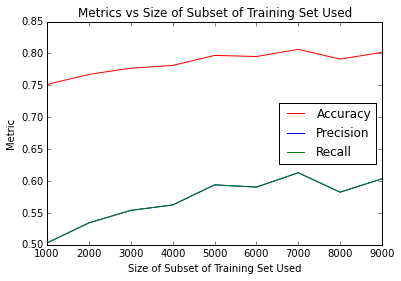

In [2]:
data = pd.read_csv('./performance_test/performance_test_train_size_0000.csv').values
plt.plot(data[:,0], data[:,1], 'r', label='Accuracy')
plt.plot(data[:,0], data[:,2], 'b', label='Precision')
plt.plot(data[:,0], data[:,3], 'g', label='Recall')
plt.xlabel('Size of Subset of Training Set Used')
plt.ylabel('Metric')
plt.title('Metrics vs Size of Subset of Training Set Used')
plt.legend(loc='best')

From this graph, it seems to show that if your size of subset increases, we increase our accuracy, however, it seems to level off quickly and one must decide if the extra computation time is worth the tiny increase in accuracy. As such for future Naive Bayes trials, we used a subset of the training size to be $N=6000$. 

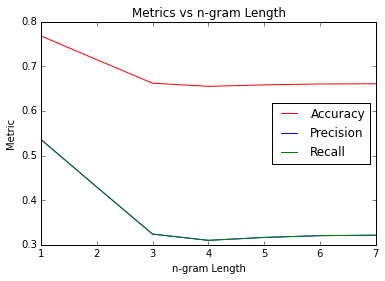

In [3]:
data = pd.read_csv('./performance_test/performance_test_ngram_0000.csv').values
plt.plot(data[:,0], data[:,1], 'r', label='Accuracy')
plt.plot(data[:,0], data[:,2], 'b', label='Precision')
plt.plot(data[:,0], data[:,3], 'g', label='Recall')
plt.xlabel('n-gram Length')
plt.ylabel('Metric')
plt.title('Metrics vs n-gram Length')
plt.legend(loc='best')

Here n-gram length is the size of our n-grams, where 1, 2, 3 are unigram, bigram and trigrams respectively. Here we clearly see that increasing the size of our n-gram without leaving the previous n-grams (as would in the cumulative n-grams) decreases our accuracy.

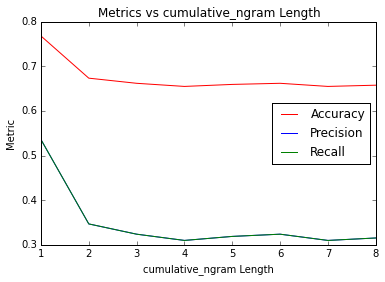

In [4]:
data = pd.read_csv('./performance_test/performance_test_cumulative_ngram_0000.csv').values
plt.plot(data[:,0], data[:,1], 'r', label='Accuracy')
plt.plot(data[:,0], data[:,2], 'b', label='Precision')
plt.plot(data[:,0], data[:,3], 'g', label='Recall')
plt.xlabel('cumulative_ngram Length')
plt.ylabel('Metric')
plt.title('Metrics vs cumulative_ngram Length')
plt.legend(loc='best')

In the cumulative ngrams, having both unigrams and bigrams or unigrams, bigrams and trigrams doesn't increase our accuracy. Thus we can safely use only unigrams in our further trials. 


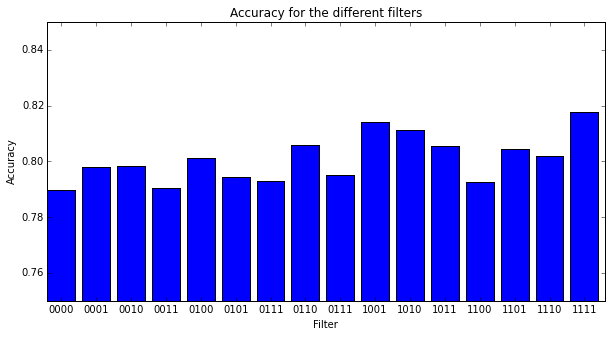

In [4]:
df = pd.read_csv('./performance_test/performance_test_ngram12_learn_codes_0000.csv')
labels = list(map(str, df['learn_code']))
labels[:9] = ['0000', '0001', '0010', '0011', '0100', '0101', '0111', '0110', '0111']
index = np.arange(len(labels))
accuracy = df['accuracy']
plt.figure(figsize=(10,5))
plt.bar(index, accuracy)
# ax = plt.gca()
plt.xticks(index+0.4, labels)
plt.title('Accuracy for the different filters')
plt.ylim([0.75,0.85])
plt.xlabel('Filter')
plt.ylabel('Accuracy')
plt.show()

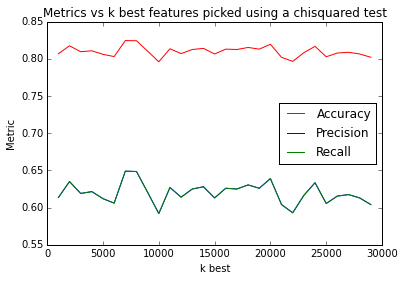

In [2]:
data = pd.read_csv('./performance_test/performance_testchi2_1111.csv').values
plt.plot(data[:,0], data[:,1], 'r', label='Accuracy')
plt.plot(data[:,0], data[:,2], 'b', label='Precision')
plt.plot(data[:,0], data[:,3], 'g', label='Recall')
plt.xlabel('k best')
plt.ylabel('Metric')
plt.title('Metrics vs k best features picked using a chisquared test')
plt.legend(loc='best')


### stuff stuart will write:
false positive/negative charts
mention how first two filters raised accuracy generally, while second two didn't do much, at least for pippin and gimli
validation percents, +/- error if --random or not

# Pros and Cons of Approach and Methodology

### Ngrams
The get_cumulative_ngrams seemed fairly successful. It takes advantage of the feature dimensionality reduction aspects of bags of words, but with some improvements. A length four ngram for example maintains the ordering of those four words. It is just very localized, but that isn't much of a drawback since there usually isn't a ton of semantic meaning packed into words being twenty words apart.

### Pippin and KNN
Pippin was a lazy learner and it showed. Training Pippin and constructing its ngram id counter was fast, but each prediction task took significantly longer than our better approaches. On a core i5 laptop it classified about ten pieces of text a second. This is partly due to our simple implementation, as finding the nearest neighbours could surely be heuristically accelerated significantly. We merely built a gigantic list of distances to all neighbours and chose the top k neighbours.

### Lowercase and Uppercase
We felt that some information is lost if we blindly set all words to lowercase. Example: "apple" and "Apple". However the way we set most words to lowercase while maintaining case on special words was flawed: if a sentence starts with "Stuart" our naive, non-semantic approach did not recognize that it should remain capitalized.

### Additive Model
The additive model used by Gimli significantly reduces the curse of dimensionality. This was a big help given text analysis through ngrams is a very high dimensional problems. Unfortunately, we inevitably had high collinearity as well, meaning two ngrams like "piano" and "violin" operate independently even though they should not because they communicate similar importance for our classifier. 

# Statement of Contributions

### Stuart
boop dee boop

### Zafarali
boop dee boop

### Hannah
boop dee boop

We	hereby	state	that	all	the	work presented	in this	report	is	that	of	the	authors

Statement of Contributions

- Zafarali Ahmed
- Stuart Spence
- Hannah Cohen

## References
*Marina Sokolova and Guy Lapalme*. A systematic analysis of performance measures for classification tasks, Information Processing and Management 2009
[pdf](http://rali.iro.umontreal.ca/rali/sites/default/files/publis/SokolovaLapalme-JIPM09.pdf)